In [1]:
from scripts import preprocessing_master
from bda import bda_utilities
from bda import rnn_utilities
from datetime import datetime
import pandas as pd
import numpy as np
import os.path

Using TensorFlow backend.


In [2]:
df = pd.read_csv("./data/df_master.csv")
df.head()

,Unnamed: 0,Date,Tag,NX,NL,CHE,DNK,CZE,LUX,SWE,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,0,2015-06-01 00:00:00,2015-06-01 00:00:00,7279.0,3932.0,145.0,-272.0,554.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,0
1,1,2015-06-01 01:00:00,2015-06-01 00:00:00,7167.0,4014.0,261.0,-141.0,469.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,0
2,2,2015-06-01 02:00:00,2015-06-01 00:00:00,6667.0,3864.0,103.0,-326.0,422.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,0
3,3,2015-06-01 03:00:00,2015-06-01 00:00:00,6413.0,4242.0,42.0,-262.0,235.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,0
4,4,2015-06-01 04:00:00,2015-06-01 00:00:00,5347.0,4292.0,-127.0,-582.0,161.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,0


In [3]:
def delete_not_needed_columns(df):
    cols = list(df.columns)
    
    cols = [x for x in cols if "month_" not in x]
    cols = [x for x in cols if "weekday_" not in x]
    delete_cols = ["Tag", "Unnamed: 0"]
    cols.remove("Tag")
    cols.remove("Unnamed: 0")
    cols.remove('de_production_mw_actual')
    
    return cols

def hendrik_to_laurin(df):
    df.astype({"Date":"datetime64"})
    df['Date']=pd.to_datetime(df['Date'])
    df.set_index("Date", drop=False, inplace=True)
    df = bda_utilities.split_datetime(df)
    cols = delete_not_needed_columns(df)
    return df[cols]

def drop_columns_with_too_many_NANs(df, missing_value_share=0.05):
    cols = list(df.columns)
    total_rows = len(df)
    count_nan = len(df) - df.count()
    for col in list(cols):
        if (count_nan[col] > missing_value_share * total_rows):
            cols.remove(col)
    return cols



In [4]:
df = hendrik_to_laurin(df)
df.head()

,Date,NX,NL,CHE,DNK,CZE,LUX,SWE,AUT,FRA,...,braunkohle[mwh],steinkohle[mwh],erdgas[mwh],pumpspeicher[mwh],sonstigekonventionelle[mwh],year,month,weekday,timestamp,hour
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,2015-06-01 00:00:00,7279.0,3932.0,145.0,-272.0,554.0,0.0,1.0,1394.0,246.0,...,0.0,0.0,0.0,0.0,0.0,2015,6,1,1.433117e+09,0
2015-06-01 01:00:00,2015-06-01 01:00:00,7167.0,4014.0,261.0,-141.0,469.0,0.0,1.0,1355.0,66.0,...,0.0,0.0,0.0,0.0,0.0,2015,6,1,1.433120e+09,1
2015-06-01 02:00:00,2015-06-01 02:00:00,6667.0,3864.0,103.0,-326.0,422.0,0.0,1.0,1574.0,-105.0,...,0.0,0.0,0.0,0.0,0.0,2015,6,1,1.433124e+09,2
2015-06-01 03:00:00,2015-06-01 03:00:00,6413.0,4242.0,42.0,-262.0,235.0,0.0,1.0,1271.0,-206.0,...,0.0,0.0,0.0,0.0,0.0,2015,6,1,1.433128e+09,3
2015-06-01 04:00:00,2015-06-01 04:00:00,5347.0,4292.0,-127.0,-582.0,161.0,0.0,1.0,1068.0,-549.0,...,0.0,0.0,0.0,0.0,0.0,2015,6,1,1.433131e+09,4


In [5]:
df = df[drop_columns_with_too_many_NANs(df)]

# drop sunhours, because they only go until 2019-05-30
df.drop(columns="dk_sun_hrs", inplace=True)

In [6]:
def custom_column_mapper(df, append_str):
    cols = df.columns
    mapper = {}
    for col in cols:
        mapper[col] = col + append_str
    return mapper

lagging_df = df[["NX", "NL", "CHE", "DNK", "CZE", "LUX", "SWE", "AUT", "FRA", "PL"]].copy()
lagging_df = lagging_df.shift(+24)
custom_column_mapper(lagging_df, "-24h")
lagging_df.rename(columns=custom_column_mapper(lagging_df, "-24h"), inplace=True)
#lagging_df['Date']=df['Date'].copy()

df = df.merge(lagging_df, left_index=True, right_index=True)
df.head()

,Date,NX,NL,CHE,DNK,CZE,LUX,SWE,AUT,FRA,...,NX-24h,NL-24h,CHE-24h,DNK-24h,CZE-24h,LUX-24h,SWE-24h,AUT-24h,FRA-24h,PL-24h
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,2015-06-01 00:00:00,7279.0,3932.0,145.0,-272.0,554.0,0.0,1.0,1394.0,246.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-01 01:00:00,2015-06-01 01:00:00,7167.0,4014.0,261.0,-141.0,469.0,0.0,1.0,1355.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-01 02:00:00,2015-06-01 02:00:00,6667.0,3864.0,103.0,-326.0,422.0,0.0,1.0,1574.0,-105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-01 03:00:00,2015-06-01 03:00:00,6413.0,4242.0,42.0,-262.0,235.0,0.0,1.0,1271.0,-206.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-01 04:00:00,2015-06-01 04:00:00,5347.0,4292.0,-127.0,-582.0,161.0,0.0,1.0,1068.0,-549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.drop(columns="Date", inplace=True)

## Preprocessing LSTM 

In [8]:
# remove outliers
df.drop(rnn_utilities.get_outliers(df, 3).index, inplace=True)

In [9]:
# remove days with missing hours
missing_days = rnn_utilities.find_days_with_missing_hours(df)
for day in missing_days:
    df.drop(df[str(day)].index, inplace=True)

In [10]:
# Drop non-target country columns.
df.drop(columns=rnn_utilities.delete_country_columns_except("SWE",df), inplace=True)

In [11]:
df.tail()

,SWE,dk_av_windspeed_ms,de_wind_ms_north,de_temp_c_north,de_wind_ms_south,de_temp_c_south,de_production_mw_planned,biomasse[mwh],wasserkraft[mwh],windoffshore[mwh],...,NX-24h,NL-24h,CHE-24h,DNK-24h,CZE-24h,LUX-24h,SWE-24h,AUT-24h,FRA-24h,PL-24h
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-02 19:00:00,-270.0,3.8,4.136667,23.860606,2.755263,22.836842,76413.0,4905.75,1363.00,2030.25,...,-6652.0,-330.0,-1273.0,-1709.0,-1273.0,471.0,-446.0,-273.0,-2705.0,886.0
2019-06-02 20:00:00,-390.0,3.8,3.866667,22.257576,2.592105,20.544737,72975.0,4907.25,1311.75,1801.25,...,-7123.0,-255.0,-1570.0,-1922.0,-1206.0,455.0,-446.0,-251.0,-2856.0,928.0
2019-06-02 21:00:00,-444.0,3.8,3.970000,21.236364,2.615789,19.160526,69887.0,4899.00,1365.75,1747.75,...,-7104.0,-99.0,-1591.0,-1982.0,-1175.0,461.0,-446.0,-425.0,-2781.0,934.0
2019-06-02 22:00:00,-446.0,3.8,4.143333,20.821212,2.728947,18.089474,68625.0,4877.50,1323.75,1726.25,...,-6931.0,452.0,-1265.0,-1974.0,-1813.0,483.0,-446.0,-753.0,-2050.0,435.0
2019-06-02 23:00:00,-56.0,3.8,4.196667,20.303030,2.684211,17.344737,66147.0,4872.75,1334.75,1455.50,...,-5892.0,914.0,-987.0,-1688.0,-1899.0,454.0,-446.0,-660.0,-1843.0,263.0


In [12]:
scaler, scaled = rnn_utilities.scale_dataframe(df)

In [13]:
from bda.rnn_utilities import make_sequence_of_length
last_training_day = "2019-04-30"
# Split into train and test sets depending on evaluation day start
values = scaled
# train until may until including last training day.
training_entries = len(df[:last_training_day])
# Ignore first 24 entries, because we don't know the prior day values
train = values[24:training_entries, :]
test = values[training_entries:, :]

#split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
# reshape input to be 3D [samples, timesteps, features]
train_X = make_sequence_of_length(24, train_X)
test_X = make_sequence_of_length(24, test_X)
# reshape output to be 3D [samples, timesteps, features]
train_y = make_sequence_of_length(24, train_y)
train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])
test_y = make_sequence_of_length(24, test_y)
test_y = test_y.reshape(test_y.shape[0], test_y.shape[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1420 samples, validate on 32 samples
Epoch 1/100
 - 4s - loss: 0.0711 - val_loss: 0.0580
Epoch 2/100
 - 2s - loss: 0.0663 - val_loss: 0.0430
Epoch 3/100
 - 2s - loss: 0.0572 - val_loss: 0.0401
Epoch 4/100
 - 2s - loss: 0.0588 - val_loss: 0.0356
Epoch 5/100
 - 2s - loss: 0.0592 - val_loss: 0.0376
Epoch 6/100
 - 2s - loss: 0.0561 - val_loss: 0.0342
Epoch 7/100
 - 2s - loss: 0.0529 - val_loss: 0.0351
Epoch 8/100
 - 2s - loss: 0.0495 - val_loss: 0.0343
Epoch 9/100
 - 2s - loss: 0.0467 - val_loss: 0.0340
Epoch 10/100
 - 2s - loss: 0.0436 - val_loss: 0.0326
Epoch 11/100
 - 2s - loss: 0.0422 - val_loss: 0.0313
Epoch 12/100
 - 3s - loss: 0.0407 - val_loss: 0.0296
Epoch 13/100
 - 2s - loss: 0.0398 - val_loss: 0.0288
Epoch 14/100
 - 2s - loss: 0.0387 - val_loss: 0.0288
Epoch 15/100
 - 2s - loss: 0.0381 - val_loss: 0.0292
Epoch 16/100
 - 2s - loss: 0.0376 - val_loss: 0.

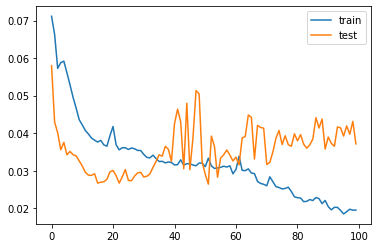

In [14]:
model = rnn_utilities.train_lstm(train_X, train_y, test_X, test_y, epochs=20)

In [15]:
df_eval = rnn_utilities.get_evaluation_df(test_X, test_y, model, scaler)


In [16]:
from sklearn.metrics import mean_squared_error
import math

math.sqrt(rnn_utilities.evaluate_model(df_eval['y'],df_eval['yhat'], mean_squared_error))

234.20963332824292

In [17]:
from sklearn.metrics import mean_absolute_error
rnn_utilities.evaluate_model(df_eval['y'],df_eval['yhat'], mean_absolute_error)

180.53741